In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf 

import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob, sys

In [2]:
dtrain0 = xr.open_dataset('data/tb_train.nc')
dval0 = xr.open_dataset('data/tb_val.nc')
dtest0 = xr.open_dataset('data/tb_test.nc')

In [3]:
# normalize data 
def datnorm(d): 
    return (d - d.mean()) / d.std() 

In [4]:
# normalize data
dtrain, dval, dtest = datnorm(dtrain0), datnorm(dval0), datnorm(dtest0)

In [5]:
int_data = dtrain['lo'].values
X_train = np.expand_dims(int_data,3)
y_train = dtrain['hi'].values

In [6]:
X_val = np.expand_dims(dval['lo'].values,3)
y_val = dval['hi'].values

In [7]:
X_test = np.expand_dims(dtest['lo'].values,3)
y_test = dtest['hi'].values

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
<xarray.Dataset> Size: 272kB
Dimensions:    (dat: 44, latitude: 24, longitude: 32, date: 44)
Coordinates:
  * latitude   (latitude) float32 96B 42.3 41.6 40.9 40.2 ... 27.6 26.9 26.2
  * longitude  (longitude) float32 128B 75.5 76.2 76.9 77.6 ... 95.8 96.5 97.2
  * date       (date) <U8 1kB '20230111' '20230117' ... '20231221' '20231226'
Dimensions without coordinates: dat
Data variables:
    pred       (dat, latitude, longitude) float32 135kB 261.8 268.0 ... 271.7
    real       (date, latitude, longitude) float32 135kB 251.8 257.0 ... 272.3
<xarray.Dataset> Size: 408kB
Dimensions:    (dat: 66, latitude: 24, longitude: 32, date: 66)
Coordinates:
  * latitude   (latitude) float32 96B 42.3 41.6 40.9 40.2 ... 27.6 26.9 26.2
  * longitude  (longitude) float32 128B 75.5 76.2 76.9 77.6 ... 95.8 96.5 97.2
  * date       (date) <U8 2kB '20230924' '20230607' ... '20230305' '20230806'
Dimensions without coordinates: dat

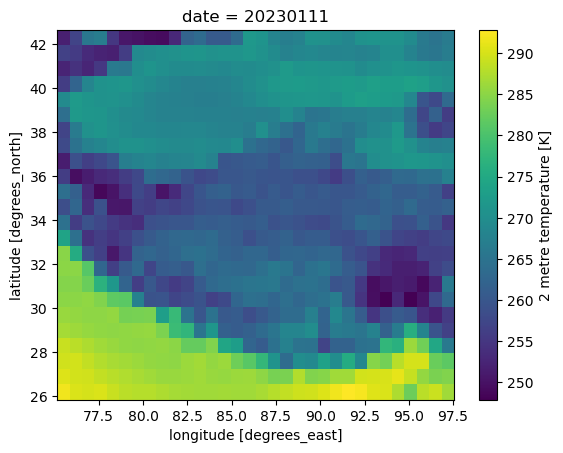

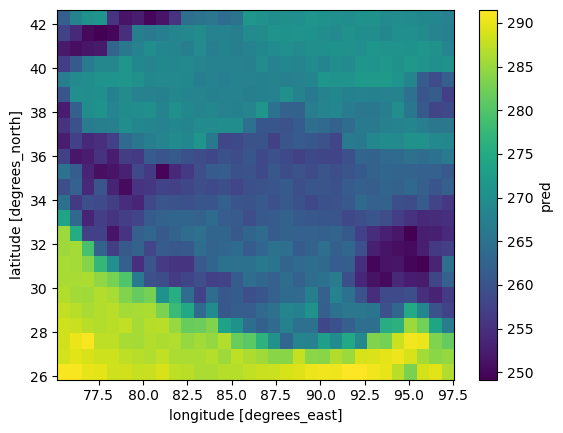

In [8]:

if 1: 
    # load model and run
    xmodel = tf.keras.models.load_model('tb_small_1.keras') 
    
    #print(xmodel.summary())
    
    y_pred_val = xmodel.predict(X_val, verbose=1)
    y_pred_test = xmodel.predict(X_test, verbose=1) 

    # return values to Kelvin 
    x1, x2 = dtest0.mean()['hi'], dtest0.std()['hi']
    y_pred_test_r = y_pred_test*x2.values + x1.values

    x1, x2 = dval0.mean()['hi'], dval0.std()['hi']
    y_pred_val_r = y_pred_val*x2.values + x1.values
    

    do = xr.Dataset( )
    do['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_test_r.squeeze())  
    do.coords['latitude'] = dtest0.latitude
    do.coords['longitude'] = dtest0.longitude
    do['real'] = dtest0['hi']

    dv = xr.Dataset( )
    dv['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_val_r.squeeze())  
    dv.coords['latitude'] = dval0.latitude
    dv.coords['longitude'] = dval0.longitude
    dv['real'] = dval0['hi']

    odir = 'output/'
    if not os.path.exists(odir): os.makedirs(odir)
    do.to_netcdf(odir+'prediction.nc')
    dv.to_netcdf(odir+'validation.nc')
    do.close()
    dv.close()
    
    #do.pred[0].plot()
    #plt.show()
    #dtest0['hi'][0].plot()
    #plt.show()
    #bias = do.pred - dtest0.hi.values
    #bias[0].plot()
    #print(bias.mean())   

    print(do)
    print(dv)
    
    do['real'][0].plot()
    plt.show()
    do['pred'][0].plot()

<xarray.DataArray 'lo' ()> Size: 4B
array(18.642609, dtype=float32)
Coordinates:
    date     <U8 32B '20230111'
<xarray.DataArray ()> Size: 4B
array(10.991943, dtype=float32)
Coordinates:
    date     <U8 32B '20230111'
<xarray.DataArray 'pred' ()> Size: 4B
array(18.32547, dtype=float32)
<xarray.DataArray 'real' ()> Size: 4B
array(19.656555, dtype=float32)
Coordinates:
    date     <U8 32B '20230111'


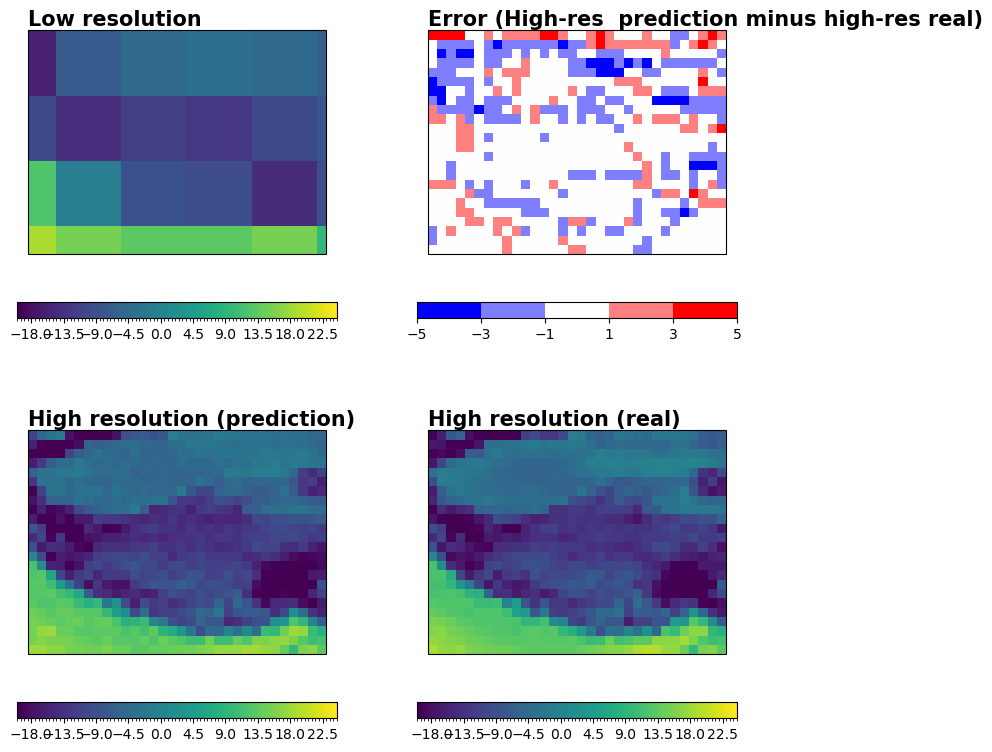

In [9]:
if 1:


    lat, lon = do.latitude.values, do.longitude.values
    ntime = 0
    zz = [ dtest0['lo'][ntime] - 273.15, do['pred'][ntime] - do['real'][ntime], 
          do['pred'][ntime]-273.15, do['real'][ntime]-273.15 ] 
    
    
    lat2d, lon2d = np.meshgrid(lon, lat)

    
    fig = plt.figure(figsize=(8,8))
    
    level = np.arange(-20., 25., .5)
    levels = [ level,  np.linspace(-5, 5, 6), level, level ] 
    
    
    for i in range(4):
        
        ax = plt.axes( [ [.1, .6, .1, .6 ][i] , 
                        [.6,.6,.1,.1][i], 
                        .4, .4 ], projection = ccrs.PlateCarree())
        
        z = zz[i]
        print(z.max())
    
        cm1 = 'viridis'
        cmap = [ plt.colormaps[ cm ] for cm in [cm1, 'bwr', cm1, cm1] ][i]
        
        norm = mpl.colors.BoundaryNorm(levels[i], cmap.N)  
        t = ax.pcolormesh(lat2d, lon2d, z, cmap=cmap, norm=norm)
    
        #cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
        #cbar = plt.colorbar(orientation="vertical", ticks=lvl[1::2])
        #cbar.ax.tick_params(labelsize=12)
    
    
        fig.colorbar(t, orientation='horizontal')
    
        ax.text( .0, 1.02, 
                ['Low resolution', 'Error (High-res  prediction minus high-res real)', 'High resolution (prediction)', 'High resolution (real)' ][i], 
                fontsize = 15, 
                fontweight = 'bold',
                transform = ax.transAxes)